# SMorph: Single Cell Analysis

---
## Setup
Please execute the cell(s) below to initialize the notebook environment.

In [1]:
# @title Install dependencies
!pip install poetry

In [2]:
# @title Install SMorph Python module
!pip install https://github.com/swanandlab/SMorph/releases/download/0.1.0/SMorph-0.1.0.tar.gz

In [3]:
import warnings
warnings.filterwarnings('ignore')  # Suppress annoying warnings

import smorph as sm
import skimage
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [4]:
def plot(img):
  """Helper one line function for plotting"""
  plt.imshow(img, cmap='gray')
  plt.show()

---
## Step 1: Load image and select preprocessing parameters

Set `IMG_PATH` as string to the path of a cell image to be analyzed

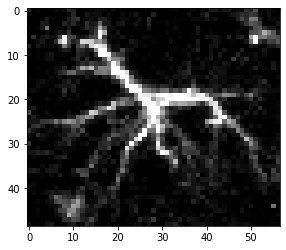

In [5]:
IMG_PATH = "Datasets/CTRLvsSTAB/control/MAX_SW MICE 2_SEC 2_GFAP_RIGHT_CA1 _CONTRA_1-2_1.tif"  #@param
cell_image = skimage.io.imread(IMG_PATH)
plot(cell_image)

Cell image preprocessing parameters:
* `min_ptile` and `max_ptile`: minimum and maximum contrast percentiles to stretch the image to
* `threshold_method`: method for single intensity auto-thresholding the cell image

Overlayed contour represents the thresholding results.

In [6]:
# @title Interactive preprocessing parameter selection
def plot_ptiles(min_ptile=2, max_ptile=98, threshold_method=sm.util.THRESHOLD_METHODS[4]):
  plt.imshow(sm.util._image._contrast_stretching(cell_image,
                                                 (min_ptile, max_ptile)),
             cmap='gray')
  mask = sm.util.preprocess_image(
    cell_image,
    'confocal',
    None,
    'manual',
    (min_ptile, max_ptile),
    threshold_method
  )[1]
  contours = skimage.measure.find_contours(mask, .9)
  for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
  # plt.imshow(mask, alpha=.5, cmap='jet', interpolation='none')

_ = widgets.interact(plot_ptiles, min_ptile=(0, 100, 1), max_ptile=(0, 100, 1), threshold_method=[*sm.util.THRESHOLD_METHODS])

interactive(children=(IntSlider(value=2, description='min_ptile'), IntSlider(value=98, description='max_ptile'…

Set the preprocessing parameters in the following cells

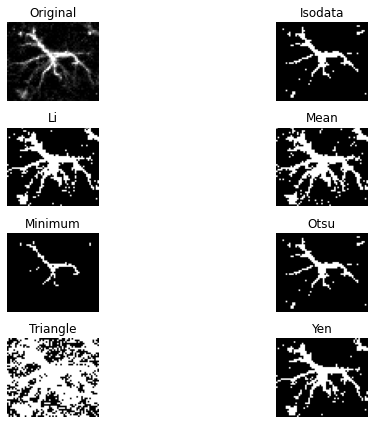

('isodata', 'li', 'mean', 'minimum', 'otsu', 'triangle', 'yen')

In [7]:
# minimum and maximum percentiles of contrast to stretch the image to
contrast_ptiles = (2, 98)  #@param

sm.util.try_all_threshold(cell_image, contrast_ptiles)
sm.util.THRESHOLD_METHODS

In [8]:
# choice of threshold method
threshold_method = sm.util.THRESHOLD_METHODS[6]  #@param
threshold_method

'yen'

---
## Step 2: Start single cell analysis

Sholl analysis parameters:
- Set `SHOLL_STEP_SIZE` as int to difference (in pixels) between concentric Sholl circles
- Set `POLYNOMIAL_DEGREE` as int to degree of polynomial for fitting regression model on Sholl values

In [9]:
SHOLL_STEP_SIZE = 3  #@param
POLYNOMIAL_DEGREE = 3  #@param

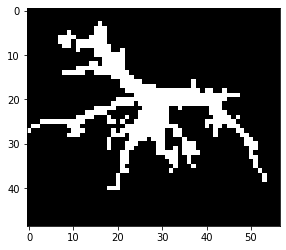

In [10]:
cell = sm.Cell(cell_image, image_type='confocal', crop_tech='manual',
               contrast_ptiles=contrast_ptiles,
               threshold_method=threshold_method,
               sholl_step_size=SHOLL_STEP_SIZE,
               polynomial_degree=POLYNOMIAL_DEGREE)
plot(cell.cleaned_image)

In [11]:
# View the extracted features
cell.features

{'surface_area': 413,
 'total_length': 180,
 'avg_process_thickness': 2.3,
 'convex_hull': 1320,
 'no_of_forks': 13,
 'no_of_primary_branches': 3,
 'no_of_secondary_branches': 7,
 'no_of_tertiary_branches': 12,
 'no_of_quatenary_branches': 9,
 'no_of_terminal_branches': 19,
 'avg_length_of_primary_branches': 5.3,
 'avg_length_of_secondary_branches': 6.7,
 'avg_length_of_tertiary_branches': 4.7,
 'avg_length_of_quatenary_branches': 5.6,
 'avg_length_of_terminal_branches': 5.2,
 'critical_radius': 12,
 'critical_value': 8.14,
 'enclosing_radius': 30,
 'ramification_index': 2.71,
 'skewness': -0.53,
 'coefficient_of_determination': 0.92,
 'sholl_regression_coefficient': 0.13,
 'regression_intercept': -0.95}

In [12]:
# View a single feature
cell.features['surface_area']

413

## Step 2.1: Skeleton Analysis
Skeletal morphological features:
* `cell.features['surface_area']`: Sum of highlighted pixels of cleaned image
* `cell.features['total_length']`: Sum of highlighted pixels of skeleton
* `cell.features['avg_process_thickness']`: Average width of all branches
* `cell.features['convex_hull']`: Sum of pixels included in the smallest convex polygon that surround whole cell
* `cell.features['no_of_forks']`: Count of all the forking (furcation) points
* `cell.features['no_of_primary_branches']`: Count of primary branches
* `cell.features['no_of_secondary_branches']`: Count of secondary branches
* `cell.features['no_of_tertiary_branches']`: Count of tertiary branches
* `cell.features['no_of_quatenary_branches']`: Count of quatenary branches
* `cell.features['no_of_terminal_branches']`: Count of terminal branches
* `cell.features['avg_length_of_primary_branches']`: Average length of primary branches
* `cell.features['avg_length_of_secondary_branches']`: Average length of secondary branches
* `cell.features['avg_length_of_tertiary_branches']`: Average length of tertiary branches
* `cell.features['avg_length_of_quatenary_branches']`: Average length of quatenary branches
* `cell.features['avg_length_of_terminal_branches']`: Average length of terminal branches
  

In [13]:
# Sum of highlighted pixels is calculated to get the skeleton area estimate
cell.features['total_length']

180

In [14]:
# Sum of highlighted pixels is calculated to get the area estimate of astrocyte
cell.features['avg_process_thickness']

2.3

1320

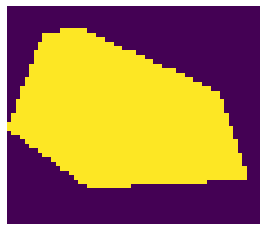

In [15]:
# Sum of pixels included in the smallest convex polygon that surround all astrocyte pixels
cell.plot_convex_hull()
cell.features['convex_hull']

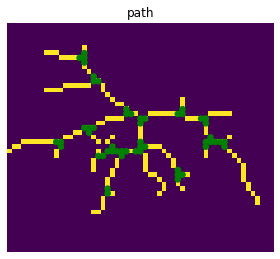

13

In [16]:
# Count all the bifurcation points
cell.plot_forks()
cell.features['no_of_forks']

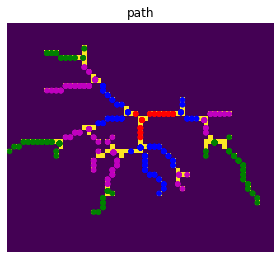

In [17]:
# The branches are differentiated into primary, secondary and further levels to compare any branch level differences between astrocytes
cell.plot_branching_structure()

## Step 2.2: Sholl Analysis

Sholl analysis morphological features:

* `cell.features['critical_radius']`: Distance at which Critical value occurs (distance at which the Highest count of intersections occurred)
* `cell.features['critical_value']`: Local maximum of the polynomial fit (Maximum no. of intersections)
* `cell.features['enclosing_radius']`: The last (thus, the widest) of intersecting radii to be associated with the number of intersections
* `cell.features['ramification_index']`: Ratio between critical value and number of primary branches
* `cell.features['skewness']`: Indication of how symmetrical the distribution is around its mean
* `cell.features['coefficient_of_determination']`: How close the data are to the fitted regression (indicative of the level of explained variability in the data)
* `cell.features['sholl_regression_coefficient']`: Rate of decay of no. of branches
* `cell.features['regression_intercept']`: Y-intercept of the logarithmic Sholl plot

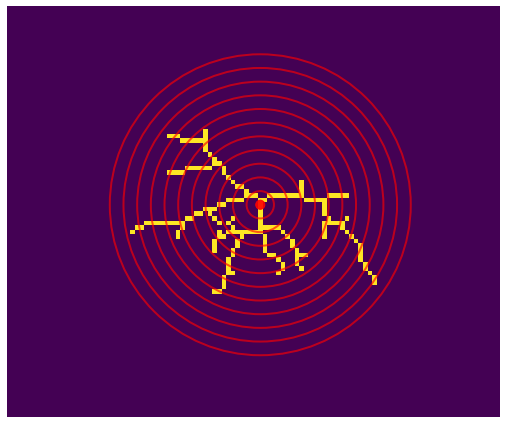

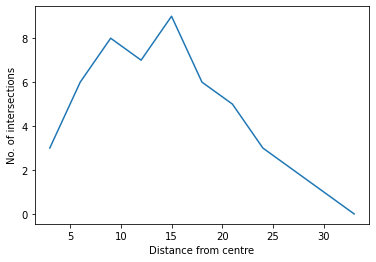

In [18]:
# Number of intersections of astrocytic branches at regular distances from the soma
cell.plot_sholl_results()

Polynomial regression is used to mitigate the influence of local variations in the sampled data, and thereby better describe the relationship between intersections vs. distance

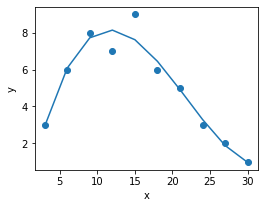

In [19]:
cell.plot_polynomial_fit()

In [20]:
# Distance at which Critical value occurs (distance at which the Highest count of intersections occurred)
cell.features['critical_radius']

12

In [21]:
# Local maximum of the polynomial fit (Maximum no. of intersections)
cell.features['critical_value']

8.14

In [22]:
# The last (thus, the widest) of intersecting radii to be associated with the number of intersections
cell.features['enclosing_radius']

30

In [23]:
# Indication of how symmetrical the distribution is around its mean
cell.features['skewness']

-0.53

In [24]:
# Ratio between critical value and number of primary branches
cell.features['ramification_index']

2.71

In [25]:
# how close the data are to the fitted regression (indicative of the level of explained variability in the data set)
cell.features['coefficient_of_determination']

0.92

In [26]:
# Rate of decay of no. of branches
cell.features['sholl_regression_coefficient']

0.13

In [27]:
# Y intercept of the logarithmic plot
cell.features['regression_intercept']

-0.95